# ModelGrid classes demo

## The three modelgrid classes `StructuredGrid`, `VertexGrid`, and `UnstructuredGrid` will be demonstrated in this notebook. 

All three classes behave similarly, as they inherit their base functionality from the same "parent" object. Even through they behave similarly, there are also some differences between the three classes based upon the specific grid type.

### This notebook will cover:

   1) __How to access the modelgrid object from a model and common usages for the modelgrid__  
   
   2) __How to build modelgrid objects from scratch__ 
   
   3) __Useful methods and features__  

In [1]:
import sys
import os
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    
from flopy.discretization import StructuredGrid, VertexGrid, UnstructuredGrid
import flopy.utils.binaryfile as bf

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
numpy version: 1.18.1
matplotlib version: 3.1.2
flopy version: 3.3.4


In [2]:
# set paths to each of our model types for this example notebook
spth = os.path.join("..", "data", "freyberg_multilayer_transient")
spth6 = os.path.join("..", "data", "mf6-freyberg")
vpth = os.path.join("..", "data")
upth = os.path.join("..", "data")
gridgen_ws = os.path.join(".", "temp")
u_data_ws = os.path.join('..', 'data', 'unstructured')

## Accessing the modelgrid and common usage

### How to access the modelgrid object from a model

FloPy model objects have a built in method that dynamically assembles a modelgrid from model discretization information. Therefore, if the user updates their DIS file, when they call the `modelgrid` property the new discretization information will be included within it. 

#### Modflow-2005 example

In [3]:
# Load a modflow-2005 model
ml = flopy.modflow.Modflow.load('freyberg.nam', model_ws=spth)

# access the modelgrid object
modelgrid = ml.modelgrid

print(type(modelgrid))

c:\users\jlarsen\desktop\flopy-dev\flopy\mbase.py:356: DeprecationWarning: xul/yul have been deprecated. Use xll/yll instead.
  DeprecationWarning,


<class 'flopy.discretization.structuredgrid.StructuredGrid'>


Spaitial refernce information that is stored in the NAM file, such as:

`xll` : geographic location of lower left model corner x-coordinate  
`yll` : geographic location of lower left model corner y-coordinate  
`rotation` : modelgrid rotation in degrees  
`epsg` : epsg code of modelgrid coordinate system  
`proj4_str` : proj4 projection information  

can be automatcally read in and applied to the modelgrid. FloPy will also write this information out when the user saves their model to file. 

This information can be seen by printing the modelgrid

In [4]:
print(modelgrid)

xll:622241.1904510253; yll:3343617.741737109; rotation:15.0; proj4_str:+proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +units=m +no_defs; units:meters; lenuni:2


#### Modflow-6 example

Modflow-6 models also have modelgrid objects attached to them. These grids function in the way. Here is an example.

In [5]:
# load a modflow-6 simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=spth6, verbosity_level=0)

# get a model object from the simulation
ml = sim.get_model("gwf_1")

# access the modelgrid
modelgrid1 = ml.modelgrid

print(type(modelgrid1))
print(modelgrid1)

<class 'flopy.discretization.structuredgrid.StructuredGrid'>
xll:0.0; yll:0.0; rotation:0.0; units:meters; lenuni:2


Note how there is no spatial reference information associated with this modelgrid. This is because, there it was not specified in the name file. In the following section, the notebook will show how to access this information from a modelgrid and how to set this information in a modelgrid object.

### Accessing and setting modelgrid reference information

#### Accessing modelgrid reference information
There are properties attached to the modelgrid that allows the user to access reference information:

   - `xoffset` : returns the x-coordinate for the modelgrid's lower left corner  
   - `yoffset` : returns the y-coordinate for the modelgrid's lower left corner  
   - `angrot` : returns the rotation of the modelgrid in degrees  
   - `epsg` : returns the modelgrid epsg code  
   - `proj4` : returns the modelgrid proj4_str information  

In [6]:
xoff = modelgrid.xoffset
yoff = modelgrid.yoffset
angrot = modelgrid.angrot
epsg = modelgrid.epsg
proj4 = modelgrid.proj4

print("xoff: {}\nyoff: {}\nangrot: {}\nepsg: {}\nproj4: {}".format(xoff, yoff, angrot, epsg, proj4))

xoff: 622241.1904510253
yoff: 3343617.741737109
angrot: 15.0
epsg: None
proj4: +proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +units=m +no_defs


#### Setting modelgrid reference information

The `set_coord_info()` method allows the user to set some or all of the modelgrid's coordinate reference information. Here is an example using the modflow6 modelgrid:

In [7]:
# show the coordinate info before setting it
print("Before: {}\n".format(modelgrid1))

# set reference infromation
modelgrid1.set_coord_info(xoff=xoff, yoff=yoff, angrot=angrot, epsg=epsg, proj4=proj4)

print("After: {}".format(modelgrid1))

Before: xll:0.0; yll:0.0; rotation:0.0; units:meters; lenuni:2

After: xll:622241.1904510253; yll:3343617.741737109; rotation:15.0; proj4_str:+proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +units=m +no_defs; units:meters; lenuni:2


*__The user can also set individual parts of the coordinate information if they do not want to supply all of the fields__*

In [8]:
# change the offsets and rotation of the modelgrid
angrot = 55
xll = 100
yll = 1000
modelgrid1.set_coord_info(xoff=xll, yoff=yll, angrot=angrot)

print(modelgrid1)

xll:100; yll:1000; rotation:55; proj4_str:+proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +units=m +no_defs; units:meters; lenuni:2


### Using the modelgrid with plotting routines

FloPy's plotting routines accept a model or modelgrid object to determine cell locations for plotting. Here is an example of plotting with the modelgrid object 

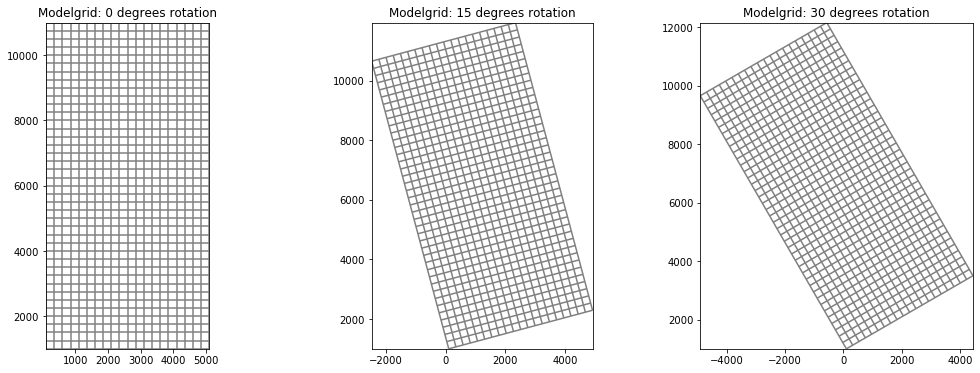

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), subplot_kw={'aspect': "equal"})

rotation = [0, 15, 30]

for ix, ax in enumerate(axs):
    modelgrid1.set_coord_info(angrot=rotation[ix])
    pmv = flopy.plot.PlotMapView(modelgrid=modelgrid1, ax=ax)
    pmv.plot_grid()
    ax.set_title("Modelgrid: {} degrees rotation".format(rotation[ix]));

The grid lines can also be plotted directly from the modelgrid object

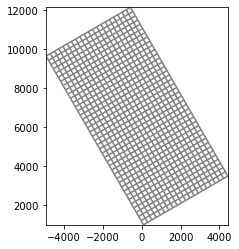

In [10]:
modelgrid1.plot();

## Building modelgrid objects from scratch

### `StructuredGrid` example

The `StructuredGrid` class can accept a number of parameters, however for a minimal working `StructuredGrid` the user only needs to provide:

   - `delc` : Array of cell widths along columns
   - `delr` : Array of cell widths along rows
   
Other optional, but useful parameters the user can supply include:
   - `top` : Array of model Top elevations
   - `botm` : Array of layer Botm elevations
   - `idomain` : An ibound or idomain array that specifies active and inactive cells
   - `lenuni` : Model length unit integer
   - `epsg` : epsg code of model coordinate system
   - `proj4` : proj4 str describining model coordinate system
   - `prj` : path to ".prj" projection file that describes the model coordinate system
   - `xoff` : x-coordinate of the lower-left corner of the modelgrid
   - `yoff` : y-coordinate of the lower-left corner of the modelgrid
   - `angrot` : model grid rotation
   - `nlay` : number of model layers
   - `nrow` : number of model rows
   - `ncol` : number of model columns
   - `laycbd` : array of length, nlay indicating if Quasi-3D confining layers exist
   

#### *In this example, some of the more common parameters are used to create a `StructuredGrid`*

In [11]:
xll = 3579
yll = 10000
rotation = 0

nrow = 40
ncol = 20
nlay = 1
Lx = 4000
Ly = 8000

# create delr and delc arrays
delr = np.ones((ncol,)) * (Lx / ncol)
delc = np.ones((nrow,)) * (Ly / nrow)

# create a sloped top and bottom
slope = np.linspace(100, 0, nrow)
slope.shape = (1, nrow)

top = np.ones((nrow, ncol)) * slope.T
botm = np.ones((nlay, nrow, ncol)) * (top - 100)

# create an ibound array
ibound = np.ones((nrow, ncol), dtype=int)
ibound[-1, 0:5] = 0
ibound[-1, 15:] = 0


modelgrid = StructuredGrid(delr=delr, delc=delc, top=top, botm=botm, idomain=ibound,
                           nlay=nlay, xoff=xll, yoff=yll, angrot=rotation)
modelgrid

xll:3579; yll:10000; rotation:0; units:undefined; lenuni:0

#### Plot some of the modelgrid information

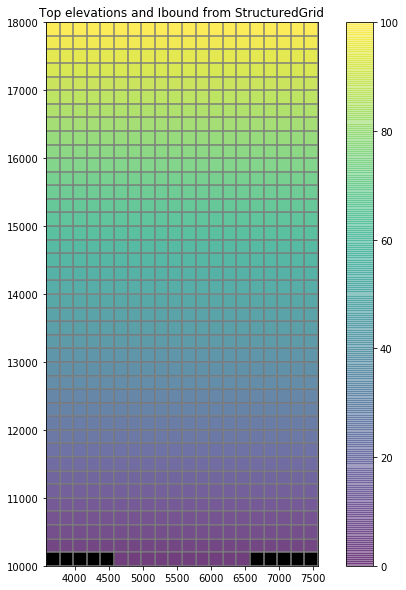

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid)
pc = pmv.plot_array(modelgrid.top, alpha=0.5)
pmv.plot_grid()
pmv.plot_ibound()

plt.colorbar(pc)
ax.set_title("Top elevations and Ibound from StructuredGrid");

#### Plot a CrossSection of the structured grid

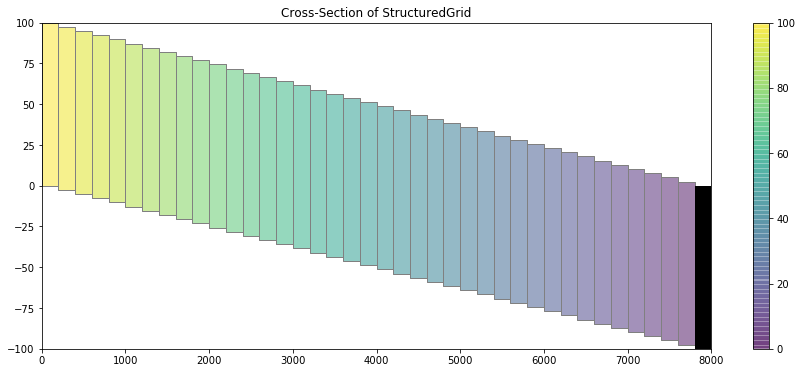

In [13]:
col = 4

figure, ax = plt.subplots(figsize=(15, 6))

xc = flopy.plot.PlotCrossSection(modelgrid=modelgrid, line={"column": col})
pc = xc.plot_array(modelgrid.top, alpha=0.5)
xc.plot_grid()
xc.plot_ibound()

plt.colorbar(pc)
plt.title("Cross-Section of StructuredGrid");

### `VertexGrid` example

Before building the `VertexGrid` class we must first develop a grid. This example uses the `Gridgen` class and executable to produce the same grid as the MODFLOW 6 Quick Start example that is shown on the main page of the flopy repository (https://github.com/modflowpy/flopy).

*NOTE*: The `Gridgen` class requires that etither a path to the executable is provided, that the executable exists in the same directory as the script, or that the executable is in the machine's PATH variables to run properly. 

In [14]:
from flopy.utils.gridgen import Gridgen
from flopy.utils.geometry import Polygon

name = 'dummy'
nlay = 3
nrow = 10
ncol = 10
delr = delc = 1.
top = 1
bot = 0
dz = (top - bot) / nlay
botm = [top - k * dz for k in range(1, nlay + 1)]

# Create a dummy model and regular grid to use as the base grid for gridgen
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=gridgen_ws, exe_name='mf6')
gwf = flopy.mf6.ModflowGwf(sim, modelname=name)

dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol, 
                              delr=delr, delc=delc,
                              top=top, botm=botm)

# Create and build the gridgen model with a refined area in the middle
g = Gridgen(dis, model_ws=gridgen_ws)
polys = [Polygon([(4, 4), (6, 4), (6, 6), (4, 6), (4, 4)])]
g.add_refinement_features(polys, 'polygon', 3, range(nlay))
g.build()

In [15]:
# get the vertex grid properties from gridgen and examine them
gridprops = g.get_gridprops_vertexgrid()
gridprops.keys()

dict_keys(['nlay', 'ncpl', 'top', 'botm', 'vertices', 'cell2d'])

#### Building the `VertexGrid`

`VertexGrid` has many similar parameters as the previous `StructuredGrid` example. For a minimal working modelgrid, `VertexGrid` requires:
   
   - `vertices` : list of vertex number, xvertex, yvertex that make up the grid
   - `cell2d` : list containing node number, xcenter, ycenter, and vertex numbers (from vertices)
   
Other optional, but useful parameters include:

   - `top` : Array of model Top elevations
   - `botm` : Array of layer Botm elevations
   - `idomain` : An ibound or idomain array that specifies active and inactive cells
   - `lenuni` : Model length unit integer
   - `epsg` : epsg code of model coordinate system
   - `proj4` : proj4 str describining model coordinate system
   - `prj` : path to ".prj" projection file that describes the model coordinate system
   - `xoff` : x-coordinate of the lower-left corner of the modelgrid
   - `yoff` : y-coordinate of the lower-left corner of the modelgrid
   - `angrot` : model grid rotation
   - `nlay` : number of model layers
   - `ncpl` : number of cells per model layer
   
#### *In this example, some of the more common parameters are used to create a `VertexGrid`*

In [16]:
vertices = gridprops['vertices']
cell2d = gridprops['cell2d']
top = gridprops['top']
botm = gridprops['botm']
nlay = gridprops['nlay']
ncpl = gridprops['ncpl']
idomain = np.ones((nlay, ncpl), dtype=int)

modelgrid = VertexGrid(vertices=vertices, cell2d=cell2d, top=top, 
                       idomain=idomain, botm=botm, nlay=nlay, ncpl=ncpl)
print(modelgrid)

xll:0.0; yll:0.0; rotation:0.0; units:undefined; lenuni:0


#### Plot some of the modelgrid information

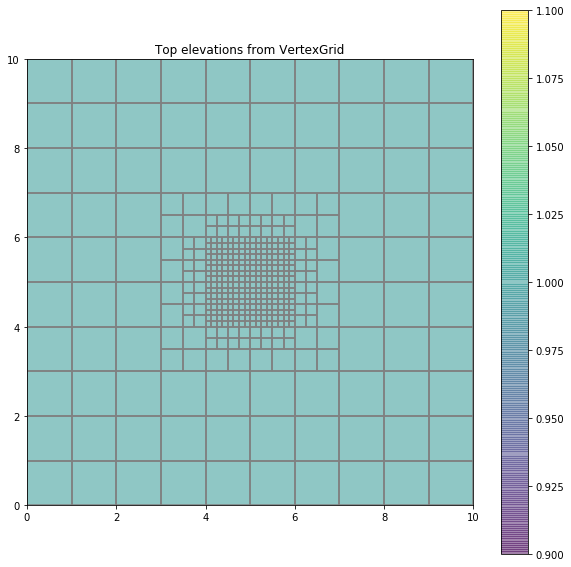

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid)
pc = pmv.plot_array(modelgrid.top, alpha=0.5)
pmv.plot_grid()
pmv.plot_ibound()

plt.colorbar(pc)
ax.set_title("Top elevations from VertexGrid");

#### Plot a CrossSection of the vertex grid

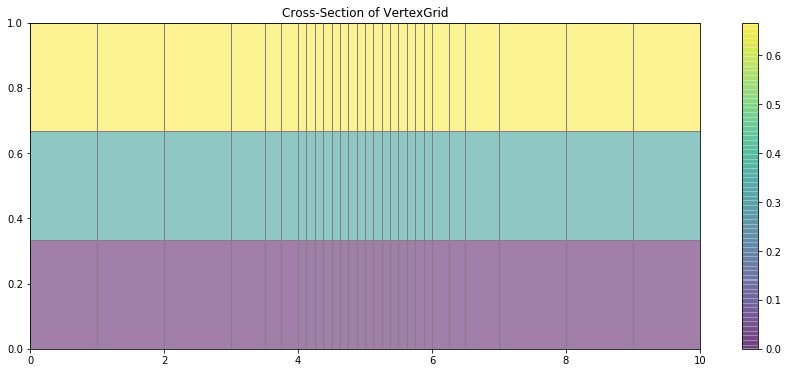

In [18]:
line = [(4.45, 0), (4.45, 10)]

figure, ax = plt.subplots(figsize=(15, 6))

xc = flopy.plot.PlotCrossSection(modelgrid=modelgrid, line={"line": line})
pc = xc.plot_array(modelgrid.botm, alpha=0.5)
xc.plot_grid()
xc.plot_ibound()

plt.colorbar(pc)
plt.title("Cross-Section of VertexGrid");

### `UnstructuredGrid` example

Before building an `UnstructuredGrid` we must first develop a grid. This example loads saved grid information from data files to create an `UnstructuredGrid`. 

*Note*: `Gridgen` can also be used to develop an unstructured grid and examples of how to do this can be found in the notebook [flopy3_gridgen.ipynb](https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3_gridgen.ipynb) 

In [19]:
# simple functions to load vertices and indice lists
def load_verts(fname):
    verts = np.genfromtxt(fname, dtype=[int, float, float], 
                         names=['iv', 'x', 'y'])
    verts['iv'] -= 1  # zero based
    return verts

def load_iverts(fname):
    f = open(fname, 'r')
    iverts = []
    xc = []
    yc = []
    for line in f:
        ll = line.strip().split()
        iverts.append([int(i) - 1 for i in ll[4:]])
        xc.append(float(ll[1]))
        yc.append(float(ll[2]))
    return iverts, np.array(xc), np.array(yc)

#### Building the `UnstructuredGrid`

`UnstructuredGrid` has many similar parameters as the previous `VertexGrid` example. For a minimal working, but "incomplete" modelgrid, `UnstructuredGrid` requires:
   
   - `vertices` : list of vertex number, xvertex, yvertex that make up the grid
   - `iverts` : list of vertex numbers that make up each cell
   - `xcenters` : list of x center coordinates for all cells in the grid if the grid
        varies by layer or for all cells in a layer if the same grid is used
        for all layers
   - `ycenters` : list of y center coordinates for all cells in the grid if the grid
        varies by layer or for all cells in a layer if the same grid is used
        for all layers
   
For a "complete" `UnstructuredGrid` these parameters must be provided in addition to the ones listed above:

   - `top` : Array of model Top elevations
   - `botm` : Array of layer Botm elevations
   
Other optional, but useful parameters include:
   
   - `idomain` : An ibound or idomain array that specifies active and inactive cells
   - `lenuni` : Model length unit integer
   - `ncpl` : one dimensional array of number of cells per model layer
   - `epsg` : epsg code of model coordinate system
   - `proj4` : proj4 str describining model coordinate system
   - `prj` : path to ".prj" projection file that describes the model coordinate system
   - `xoff` : x-coordinate of the lower-left corner of the modelgrid
   - `yoff` : y-coordinate of the lower-left corner of the modelgrid
   - `angrot` : model grid rotation   
   
#### *In this example, some of the more common parameters are used to create a `UnstructuredGrid`*

In [20]:
# load vertices
fname = os.path.join(u_data_ws, 'ugrid_verts.dat')
verts = load_verts(fname)

# load the index list into iverts, xc, and yc
fname = os.path.join(u_data_ws, 'ugrid_iverts.dat')
iverts, xc, yc = load_iverts(fname)

# create a 3 layer model grid
ncpl = np.array(3 * [len(iverts)])
nnodes = np.sum(ncpl)

top = np.ones((nnodes))
botm = np.ones((nnodes))

# set top and botm elevations
i0 = 0
i1 = ncpl[0]
elevs = [100, 0, -100, -200]
for ix, cpl in enumerate(ncpl):
    top[i0:i1] *= elevs[ix]
    botm[i0:i1] *= elevs[ix + 1]
    i0 += cpl
    i1 += cpl
    
# create the modelgrid
modelgrid = UnstructuredGrid(vertices=verts, iverts=iverts, xcenters=xc, 
                             ycenters=yc, top=top, botm=botm, ncpl=ncpl)
    

#### Plot some of the modelgrid information

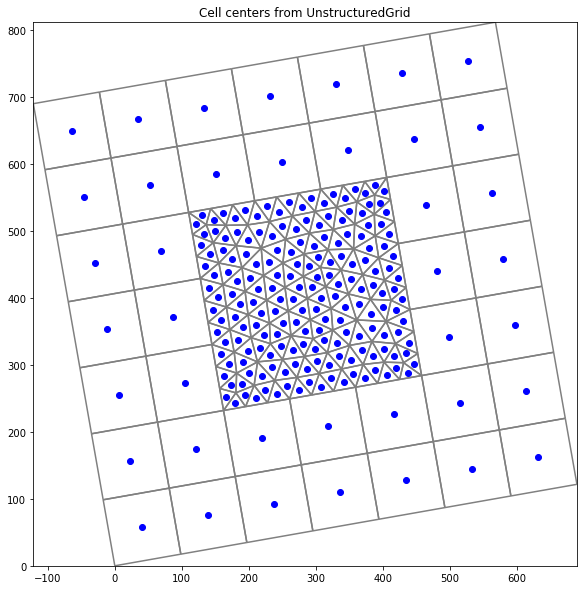

In [21]:
# rotate the modelgrid for the fun of it
modelgrid.set_coord_info(angrot=10)

fig, ax = plt.subplots(figsize=(10, 10))

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid)
pmv.plot_grid()

# plot cell centers
plt.plot(modelgrid.xcellcenters, modelgrid.ycellcenters, 'bo')

ax.set_title("Cell centers from UnstructuredGrid");

#### Plot a CrossSection of the unstructured grid

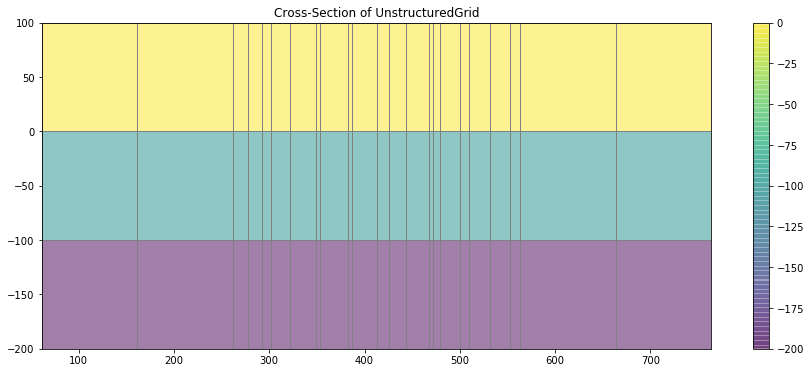

In [22]:
line = [(350, 0), (300, 800)]

figure, ax = plt.subplots(figsize=(15, 6))

# note geographic_coords=True should be set for unstructured grid cross-sections
xc = flopy.plot.PlotCrossSection(modelgrid=modelgrid, line={"line": line}, geographic_coords=True)
pc = xc.plot_array(modelgrid.botm, alpha=0.5)
xc.plot_grid()

plt.colorbar(pc)
plt.title("Cross-Section of UnstructuredGrid");

## Useful methods and properties of the modelgrid classes

Many of the useful methods and features of the modelgrid classes will be presented in this section of the Notebook. The modelgrid classes have a large number of common properties and methods that we will explore. Let's first load a model and look at all of the common features.

In [23]:
# load a modflow-6 freyberg simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=spth6, verbosity_level=0)

# get a model object from the simulation
ml = sim.get_model("gwf_1")

# access the modelgrid
modelgrid = ml.modelgrid

# and set the coordinate info
modelgrid.set_coord_info(
    xoff=622241.1904510253,
    yoff=3343617.741737109,
    angrot=15.0,
    proj4="+proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
)

### Common properties

There are many common (shared) properties that are present in `StructuredGrid`, `VertexGrid`, and `UnstructuredGrid`:


#### Grid info properties

   - `is_valid` : returns True if modelgrid is valid
   - `is_complete` : returns True if modelgrid has all basic information and `top`, `botm`, and `idomain` have been set
   - `grid_type` : returns a string representation of the grid type ("structured", "vertex", or "unstructured")
   - `units` : returns a string representation of model units
   - `lenuni` : returns an integer representation of model units
   - `extent` : returns the modelgrid extent as (xmin, xmax, ymin, ymax)  
   

In [24]:
# print grid info properties
if modelgrid.is_valid and modelgrid.is_complete:
    print("{} modelgrid is valid and complete\n".format(modelgrid.grid_type))

print("lenuni: {}, units: {}\n".format(modelgrid.lenuni, modelgrid.units))

print("lower left corner: ({0}, {2}), upper right corner: ({1}, {3})".format(*modelgrid.extent))

structured modelgrid is valid and complete

lenuni: 2, units: meters

lower left corner: (619653.0, 3343617.741737109), upper right corner: (627070.8195824706, 3354571.0952255125)


#### Spatial reference properties

   - `xoffset` : returns the current xoffset of the modelgrid
   - `yoffset` : returns the current yoffset of the modelgrid
   - `angrot` : returns the angle of rotation of the modelgrid in degrees
   - `angrot_radians` : returns the angle of rotation of the modelgrid in radians
   - `epsg` : returns the modelgrid epsg code if it is set
   - `proj4` : returns the modelgrid proj4 string if it is set
   - `prj` : returns the path to the modelgrid projection file if it is set

In [25]:
# Access and print some of these properties
print("xoffset: {}, yoffset: {}\n".format(modelgrid.xoffset, modelgrid.yoffset))
print("rotation (deg): {:.1f}, (rad): {:.4f}\n".format(modelgrid.angrot, modelgrid.angrot_radians))
print("proj4_str: {}".format(modelgrid.proj4))

xoffset: 622241.1904510253, yoffset: 3343617.741737109

rotation (deg): 15.0, (rad): 0.2618

proj4_str: +proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +units=m +no_defs


#### Model discretization properties
   
   - `shape` : returns the shape of the modelgrid (tuple)
   - `ncpl` : returns the number of cells per layer
   - `nnodes` : returns the number of cells in the model
   - `top` : returns an array of the top elevation of the model or for unstructured grids the top elevation of all cells
   - `botm` : retuns an array of the botm elevations of model cells
   - `thick` : returns an array of model cell thickness
   - `idomain` : retruns the idomain array associated with the model
   - `xvertices` : returns an array of x-vertices for model cells
   - `yvertices` : returns an array of y-vertices for model cells
   - `zvertices` : returns an array of z-vertices for model cells
   - `xcellcenters` : returns an array of x-vertices for model cell centers
   - `ycellcenters` : returns an array of y-vertices for model cell centers
   - `verts` : returns a list of vertex number, x-coordinate, y-coordinate
   - `iverts` : returns a list of cell number, vertex numbers for each cell

In [26]:
# look at some model discretization information

print("Grid shape: {}\n".format(modelgrid.shape))
print("number of cells per layer: {}\n". format(modelgrid.ncpl))
print("number of cells in model: {}".format(modelgrid.nnodes))

Grid shape: (1, 40, 20)

number of cells per layer: 800

number of cells in model: 800


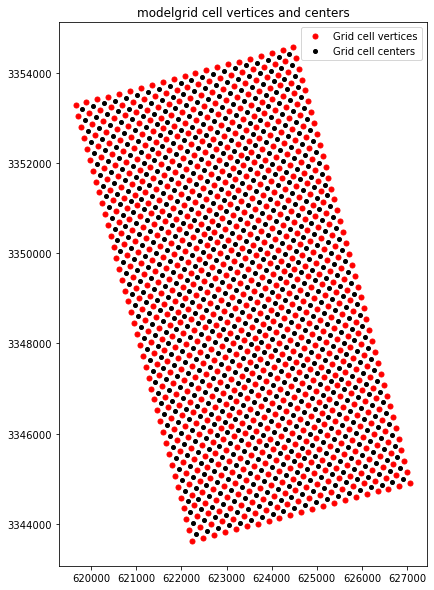

In [27]:
# plot the model cell vertices and cell centers
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'aspect': "equal"})

ax.plot(np.ravel(modelgrid.xvertices), np.ravel(modelgrid.yvertices), 'ro', label="Grid cell vertices", ms=5)
ax.plot(np.ravel(modelgrid.xcellcenters), np.ravel(modelgrid.ycellcenters), 'ko', label="Grid cell centers", ms=4)
plt.legend(loc=0, )
plt.title("modelgrid cell vertices and centers");

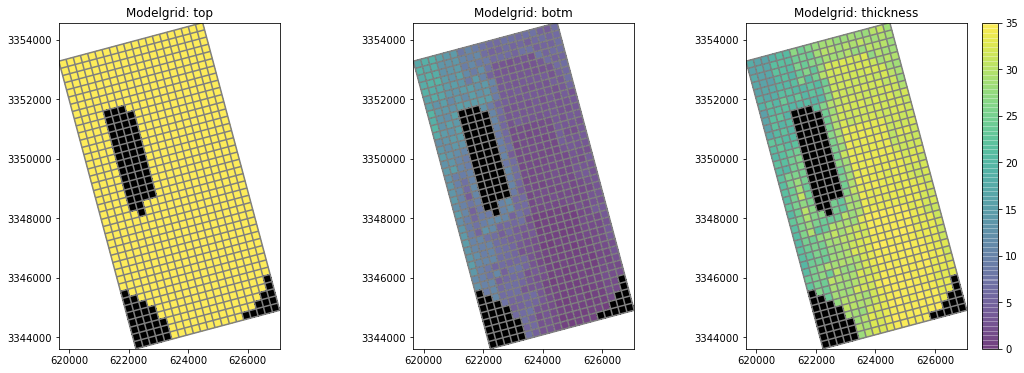

In [28]:
# plot layer 1 top, botm, and thickness with ibound overlain 
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), subplot_kw={'aspect': "equal"})

arrays = [
    modelgrid.top,
    modelgrid.botm,
    modelgrid.thick
]

labels = ['top', "botm", "thickness"]

# plot arrays
for ix, ax in enumerate(axs):        
    pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
    pc = pmv.plot_array(arrays[ix], masked_values=[1e+30], vmin=0, vmax=35, alpha=0.5)
    pmv.plot_grid()
    pmv.plot_inactive()
    ax.set_title("Modelgrid: {}".format(labels[ix]))
    
plt.colorbar(pc);

### Common methods

There are also many common (shared) methods that are present in `StructuredGrid`, `VertexGrid`, and `UnstructuredGrid`:

#### Overview of methods

   - `set_coord_info()` : Method to set coordinate reference information for the modelgrid
   - `get_coords()` : Method to convert model coordinates to real-world coordinates based on coordinate reference information
   - `get_local_coords()` : Method to convert real-world coordinates to model coordinates based on coordinate reference information
   - `intersect()` : Method to get the cellid (`StructuredGrid`=(row, column) OR `VertexGrid` & `UnstrucuturedGrid`=node number) from either model coordinates or from real-world coordinates
   - `saturated_thick()` : Method to get the saturated thickness
   - `write_shapefile()` : Method to write a shapefile of the grid with just the cellid attributes

#### set_coord_info()

Method to set coordinate reference information for the modelgrid. This method accepts the following optional parameters:

   - `xoff` : lower-left corner of modelgrid x-coordinate location
   - `yoff` : lower-left corner of modelgrid y-coordinate location
   - `angrot` : rotation of model grid in degrees
   - `epsg` : epsg code for model grid projection
   - `proj4` : proj4 string describing the model grid projection
   - `merge_coord_info` : boolean flag to either merge changes with the existing coordinate info or clear existing coordinate info before applying changes.

xll:50000; yll:3343617.741737109; rotation:15.0; proj4_str:+proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +units=m +no_defs; units:meters; lenuni:2
xll:0.0; yll:0.0; rotation:45; units:meters; lenuni:2


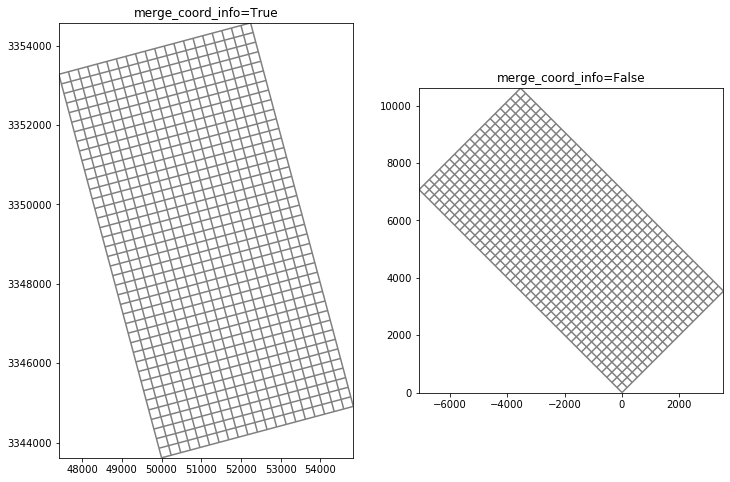

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), subplot_kw={'aspect': "equal"})

# example usage with merge_coord_info=True
modelgrid.set_coord_info(xoff=50000)
print(modelgrid)
modelgrid.plot(ax=ax[0])
ax[0].set_title("merge_coord_info=True")

# example usage with merge_coord_info=False
modelgrid.set_coord_info(angrot=45, merge_coord_info=False)
print(modelgrid)
modelgrid.plot(ax=ax[1])
ax[1].set_title("merge_coord_info=False");

#### get_coords()

Method to convert model coordinates to real-world coordinates based on coordinate reference information. Input parameters include:

   - `x` : float, list, or array of x coordinate values
   - `y` : float, list, or array of y coordinate values

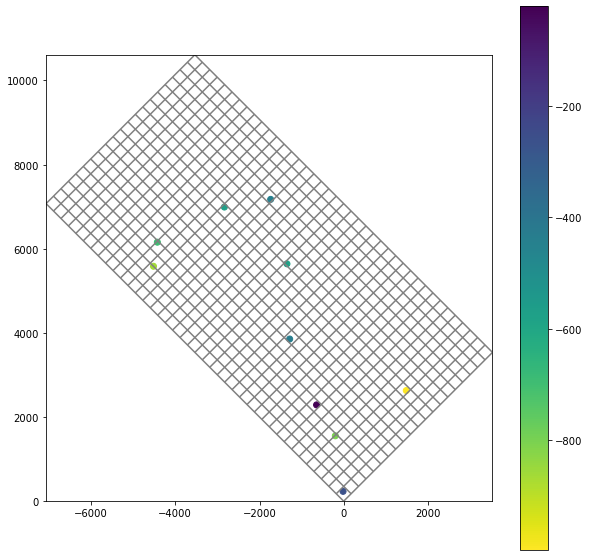

In [30]:
# create some synthetic pumping data
x = modelgrid.xoffset + np.random.rand(10)*4000
y = modelgrid.yoffset + np.random.rand(10)*10000
q = np.random.rand(10) * -1000

# get "real-world coordinates"
rw_coords = modelgrid.get_coords(x, y)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'aspect': "equal"})

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pmv.plot_grid()

s = ax.scatter(rw_coords[0], rw_coords[1], c=q, cmap="viridis_r")
plt.colorbar(s);

#### get_local_coords()

Method to convert real-world coordinates to local coordinates based on coordinate reference information. Input parameters include:

   - `x` : float, list, or array of x coordinate values
   - `y` : float, list, or array of y coordinate values

True
True


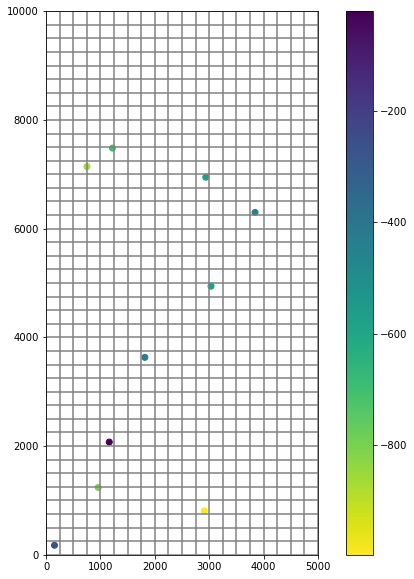

In [31]:
# reuse the "real world" coordinates from the previous cell
l_coords = modelgrid.get_local_coords(rw_coords[0], rw_coords[1])

# show that these have been properly translated
print(np.allclose(x, l_coords[0]))
print(np.allclose(y, l_coords[1]))

# plot the local coords on a modelgrid that is in model units 
modelgrid.set_coord_info(merge_coord_info=False)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'aspect': "equal"})

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pmv.plot_grid()

s = ax.scatter(l_coords[0], l_coords[1], c=q, cmap="viridis_r")
plt.colorbar(s);

#### `intersect()` 

Method to get the cellid (`StructuredGrid`=(row, column) OR `VertexGrid` & `UnstrucuturedGrid`=node number) from either model coordinates or from real-world coordinates. Parameters include:

   - `x` : x coordinate value
   - `y` : y coordinate value
   - `local` : if True x and y are in local coordinates (default is False)
   - `forgive` : forgive x, y coordinate pairs and return NaN when coordinate pairs fall outside the model domain (default is False)

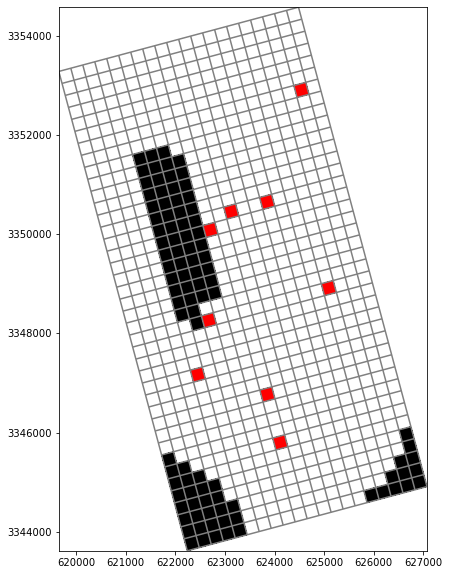

In [32]:
# apply rotation, xoffset, and yoffset to modelgrid
modelgrid.set_coord_info(
    xoff=622241.1904510253,
    yoff=3343617.741737109,
    angrot=15.0,
)

# generate some synthetic pumping data
x = modelgrid.xoffset + np.random.rand(10)*4000
y = modelgrid.yoffset + np.random.rand(10)*10000
q = np.random.rand(10) * -0.02

# intersect to get row and column locations and create pumping data
pdata = []
for ix, xc in enumerate(x):
    i, j = modelgrid.intersect(xc, y[ix], forgive=True)
    if not np.isnan(i) and not np.isnan(j):
        if modelgrid.idomain[0, i, j]:
            pdata.append([(0, i, j), q[ix]])

# create a mf6 WEL package and add it to the existing model
stress_period_data = {0: pdata}
wel = flopy.mf6.modflow.ModflowGwfwel(ml, stress_period_data=stress_period_data)

# plot the locations from the new WEL package on the modelgrid
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'aspect': "equal"})

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pmv.plot_grid()
pmv.plot_inactive()
pmv.plot_bc(package=wel);

#### saturated_thick()

Method to calculate the saturated thickness of each model cell from an array of elevations. Input parameters to this method include:

   - `array` : array of elevations that will be used to adjust the cell thickness
   - `mask` : float, list, tuple, or array of values to replace with a NaN value (ex. hdry and hnoflo values)
   


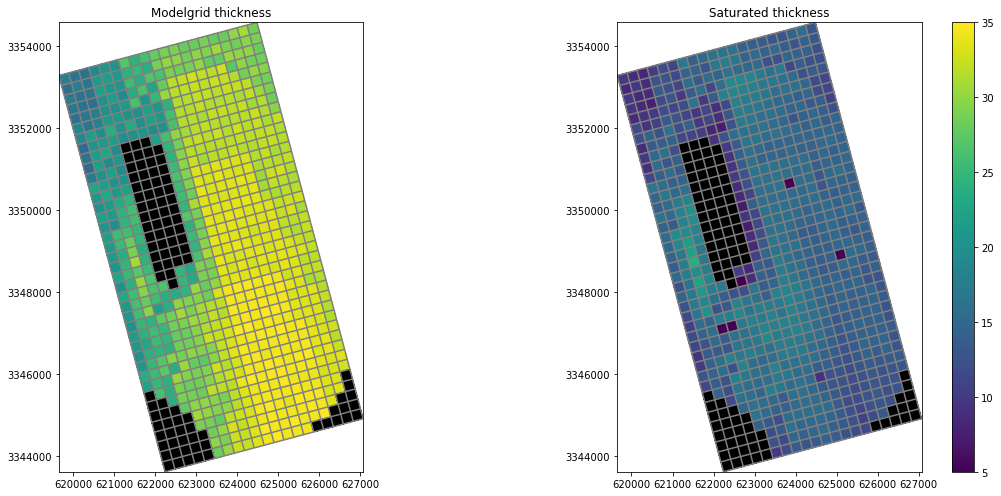

In [33]:
# write inputs and run the mf6 simulation with the new wells we added above
cpth = os.path.join(".", "temp")
sim.simulation_data.mfpath.set_sim_path(cpth)
sim.write_simulation()
sim.run_simulation()

# load the binary head file from the model
ml = sim.gwf_1
hds = ml.output.head()
head = hds.get_alldata()[0]

# calculate saturated thickness
sat_thk = ml.modelgrid.saturated_thick(head, mask=[1e30])

# get thick for comparison
thk = ml.modelgrid.thick

# plot thickness and saturated thickness for comparison
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7), subplot_kw={'aspect': "equal"})

pmv = flopy.plot.PlotMapView(modelgrid=ml.modelgrid, ax=ax[0])
pc = pmv.plot_array(thk, vmin=5, vmax=35)
pmv.plot_ibound()
pmv.plot_grid()
ax[0].set_title("Modelgrid thickness")

pmv = flopy.plot.PlotMapView(modelgrid=ml.modelgrid, ax=ax[1])
pc = pmv.plot_array(sat_thk, vmin=5, vmax=35)
pmv.plot_ibound()
pmv.plot_grid()
ax[1].set_title("Saturated thickness")

plt.tight_layout()
plt.colorbar(pc);

#### `write_shapefile()` 

Method to write a shapefile of the grid with just the cellid attributes. Input parameters include:

   - `filename` : shapefile name
   - `epsg` : optional epsg code of the coordinate system projection
   - `prj` : optional, input projection file to be used to define the coordinate system projection

In [34]:
# write a shapefile
shp_name = os.path.join('.', 'temp', 'freyberg-6_grid.shp')
epsg = "32614"

ml.modelgrid.write_shapefile(shp_name, epsg)

wrote .\temp\freyberg-6_grid.shp
